In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import logging
from pathlib import Path

import mat73
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.baseline import Baseline
from hb_mep.models.utils import Site as site
from hb_mep.utils import plot, timing
from hb_mep.utils.constants import (
    INTENSITY,
    RESPONSE,
    PARTICIPANT,
    FEATURES
)

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH


#### Load data and preprocess

In [4]:
data = DataClass(config)

a, b = 1, 4
df = None

for i in range(a, b):
    participant = f"amap{i:02}"
    PREFIX = f"rats_data/{participant}/*"

    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*auc_table.csv"))[0]
    temp_df = pd.read_csv(fpath)

    fpath = glob.glob(os.path.join(data.data_path, f"{PREFIX}/*ep_matrix.mat"))[0]
    data_dict = mat73.loadmat(fpath)
    temp_mat = data_dict["ep_sliced"]

    if df is None:
        time = data_dict["t_sliced"]
    else:
        assert((data_dict["t_sliced"] == time).all())

    temp_df["participant"] = participant
    temp_df["segment"] = temp_df.channel2_segment
    temp_df["method"] = temp_df.channel2_laterality

    idx = temp_df.channel1_segment.isna()
    temp_df = temp_df[idx].copy()
    temp_df.reset_index(drop=True, inplace=True)

    temp_mat = temp_mat[idx, :, :]

    if df is None:
        df = temp_df.copy()
        mat = temp_mat
    else:
        df = pd.concat([df, temp_df], ignore_index=True).copy()
        mat = np.vstack((mat, temp_mat))

df.reset_index(drop=True, inplace=True)

df, encoder_dict = data.build(df)


2023-05-26 15:49:34,947 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-26 15:49:34,955 - hb_mep.utils.utils - INFO - func:preprocess took: 0.01 sec
2023-05-26 15:49:34,955 - hb_mep.utils.utils - INFO - func:build took: 0.01 sec


#### Plot data

In [5]:
# plot(df, encoder_dict=encoder_dict, mat=mat[:, :, 0], time=time);

In [6]:
from numpyro.distributions.mixtures import MixtureGeneral


class MixtureModel(Baseline):
    def __init__(self, config: HBMepConfig):
        super(MixtureModel, self).__init__(config=config)
        self.name = "Mixture_Model"

        self.columns = [PARTICIPANT] + FEATURES
        self.x = np.linspace(0, 450, 1000)

    def _model(self, intensity, participant, feature0, feature1, response_obs=None):
        n_data = intensity.shape[0]
        n_participant = np.unique(participant).shape[0]
        n_feature0 = np.unique(feature0).shape[0]
        n_feature1 = np.unique(feature1).shape[0]

        with numpyro.plate("n_participant", n_participant, dim=-1):
            # Hyperriors
            a_mean = numpyro.sample(
                site.a_mean,
                dist.TruncatedDistribution(dist.Normal(150, 50), low=0)
            )
            a_scale = numpyro.sample(site.a_scale, dist.HalfNormal(20))

            b_scale = numpyro.sample(site.b_scale, dist.HalfNormal(0.1))

            h_scale = numpyro.sample("h_scale", dist.HalfNormal(10))
            v_scale = numpyro.sample("v_scale", dist.HalfNormal(10))

            lo_scale = numpyro.sample(site.lo_scale, dist.HalfNormal(0.2))

            noise_offset_scale = numpyro.sample(
                site.noise_offset_scale,
                dist.HalfCauchy(0.2)
            )
            noise_slope_scale = numpyro.sample(
                site.noise_slope_scale,
                dist.HalfCauchy(0.2)
            )

            noise_mixture = numpyro.sample(
                "noise_mixture",
                dist.HalfCauchy(0.2)
            )

            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate("n_feature1", n_feature1, dim=-3):
                    # Priors
                    a = numpyro.sample(
                        site.a,
                        dist.TruncatedDistribution(dist.Normal(a_mean, a_scale), low=0)
                    )
                    b = numpyro.sample(site.b, dist.HalfNormal(b_scale))

                    h = numpyro.sample("h", dist.HalfNormal(h_scale))
                    v = numpyro.sample("v", dist.HalfNormal(v_scale))

                    lo = numpyro.sample(site.lo, dist.HalfNormal(lo_scale))

                    noise_offset = numpyro.sample(
                        site.noise_offset,
                        dist.HalfCauchy(noise_offset_scale)
                    )
                    noise_slope = numpyro.sample(
                        site.noise_slope,
                        dist.HalfCauchy(noise_slope_scale)
                    )

        """ Model """
        mean = numpyro.deterministic(
            site.mean,
            lo[feature1, feature0, participant] + \
            jnp.maximum(
                0,
                -1 + \
                (h[feature1, feature0, participant] + 1) / \
                jnp.power(
                    1 + \
                    (jnp.power(1 + h[feature1, feature0, participant], v[feature1, feature0, participant]) - 1) * \
                    jnp.exp(-b[feature1, feature0, participant] * (intensity - a[feature1, feature0, participant])),
                    1 / v[feature1, feature0, participant]
                )
            )
        )

        sigma = numpyro.deterministic(
            "sigma",
            noise_offset[feature1, feature0, participant] + \
            noise_slope[feature1, feature0, participant] * \
            mean
        )

        mixing_distribution = dist.Categorical(probs=jnp.array([0.9, 0.1]))

        component_distributions = [
            dist.TruncatedNormal(mean, sigma, low=0),
            dist.TruncatedNormal(
                0,
                noise_mixture[participant],
                low=0
            )
        ]

        Mixture = MixtureGeneral(
            mixing_distribution=mixing_distribution,
            component_distributions=component_distributions
        )

        with numpyro.plate("data", n_data):
            return numpyro.sample("obs", Mixture, obs=response_obs)

    @timing
    def run_inference(self, df: pd.DataFrame) -> tuple[numpyro.infer.mcmc.MCMC, dict]:
        """
        Run MCMC inference
        """
        response = df[RESPONSE].to_numpy().reshape(-1,)
        participant = df[PARTICIPANT].to_numpy().reshape(-1,)
        feature0 = df[FEATURES[0]].to_numpy().reshape(-1,)
        feature1 = df[FEATURES[1]].to_numpy().reshape(-1,)
        intensity = df[INTENSITY].to_numpy().reshape(-1,)

        # MCMC
        nuts_kernel = NUTS(self._model)
        mcmc = MCMC(nuts_kernel, **self.config.MCMC_PARAMS)
        rng_key = jax.random.PRNGKey(self.random_state)
        # logger.info(f"Running inference with {self.name} ...")
        mcmc.run(rng_key, intensity, participant, feature0, feature1, response)
        posterior_samples = mcmc.get_samples()

        return mcmc, posterior_samples

    def _get_estimates(
        self,
        posterior_samples: dict,
        posterior_means: dict,
        c: tuple
    ):
        a = posterior_means[site.a][c[::-1]]
        b = posterior_means[site.b][c[::-1]]
        h = posterior_means["h"][c[::-1]]
        v = posterior_means["v"][c[::-1]]
        lo = posterior_means[site.lo][c[::-1]]

        y = lo + jnp.maximum(
            0,
            -1 + (h + 1) / \
            jnp.power(1 + (jnp.power(1 + h, v) - 1) * jnp.exp(-b * (self.x - a)), 1 / v)
        )

        threshold_samples = posterior_samples[site.a][:, c[2], c[1], c[0]]
        hpdi_interval = hpdi(threshold_samples, prob=0.95)

        return y, threshold_samples, hpdi_interval


#### Initialize model

In [7]:
model = MixtureModel(config)

#### Run MCMC inference

In [8]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-05-26 15:49:35,612 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-26 15:49:35,613 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-26 15:49:35,613 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-26 15:49:35,614 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-26 15:49:35,614 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

#### Diagnostics

In [ ]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
             a[0,0,0]    124.01      2.67    124.30    120.17    128.34  11789.04      1.00
             a[0,0,1]     45.60      1.35     45.78     43.45     47.61  11705.39      1.00
             a[0,0,2]     33.14      4.82     34.96     26.05     39.16   4296.80      1.00
             a[0,1,0]    128.53      2.32    128.63    124.95    131.94  12305.21      1.00
             a[0,1,1]    121.78      1.70    121.94    119.27    124.07   3128.40      1.00
             a[0,1,2]    112.90      4.87    112.20    105.43    121.06   5374.38      1.00
             a[0,2,0]    207.68      3.11    207.61    202.84    211.63   6657.36      1.00
             a[0,2,1]    227.07      2.43    227.55    223.16    229.80   1451.05      1.00
             a[0,2,2]    168.04      5.48    169.46    158.41    175.40   5472.39      1.00
             a[0,3,0]    207.14      3.28    207.26    201.48    212.17  14793.

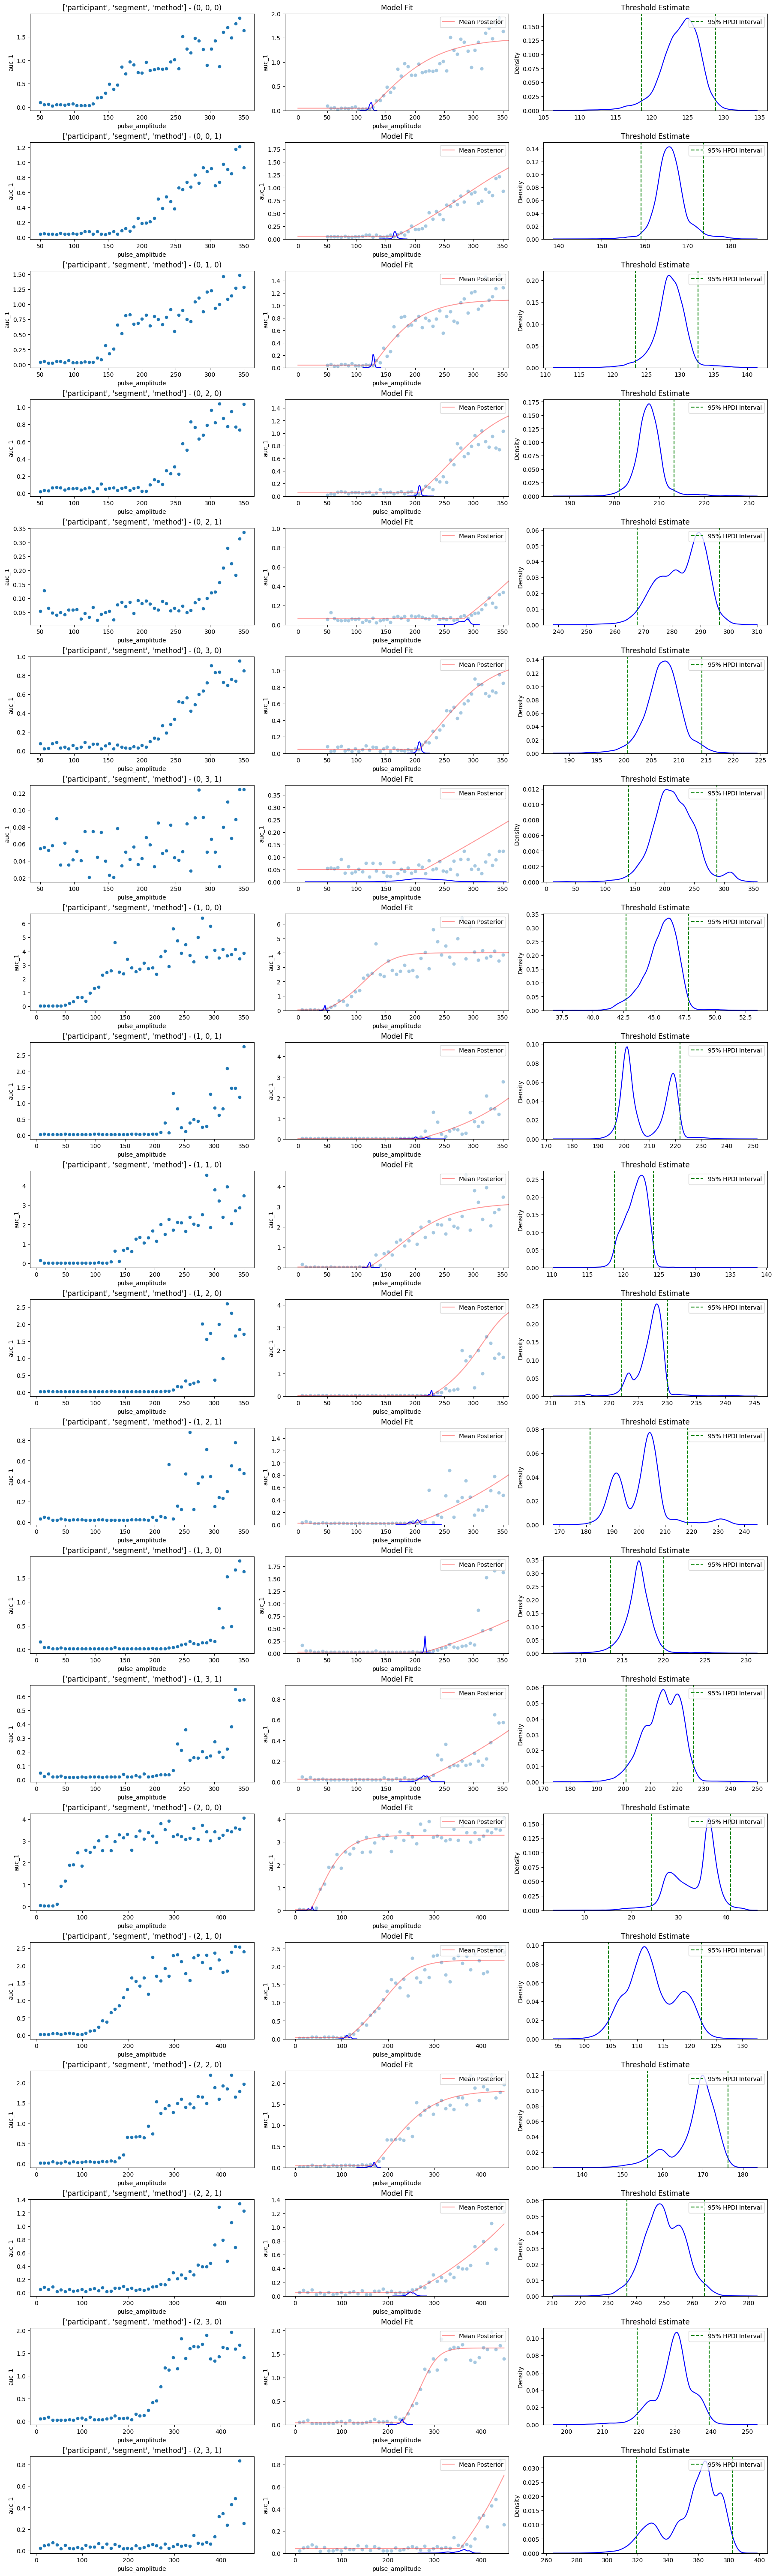

In [ ]:
model.plot(df=df, posterior_samples=posterior_samples);